<a href="https://colab.research.google.com/github/ion-bueno/bert-from-inside/blob/main/Deep%20Learning/3.%20CNNs/STUDENT_Lab_3_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 Part 2: Batch Normalization 


------------------------------------------------------
*Deep Learning. Master in Big Data Analytics*

*Pablo M. Olmos pamartin@ing.uc3m.es*

*José Carlos Aradillas Jaramillo jaradill@ing.uc3m.es*

------------------------------------------------------

Batch normalization was introduced in Sergey Ioffe's and Christian Szegedy's 2015 paper [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf). The idea is that, instead of just normalizing the inputs to the network, we normalize the inputs to _layers within_ the network. 

> It's called **batch** normalization because during training, we normalize each layer's inputs by using the mean and variance of the values in the current *batch*.

We will first analyze the effect of Batch Normalization (BN) in a simple NN with dense layers. Then you will be able to incorportate BN into the CNN that you designed in the first part of Lab 3. 

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

## Batch Normalization in PyTorch<a id="implementation_1"></a>

This section of the notebook shows you one way to add batch normalization to a neural network built in PyTorch. 

The following cells import the packages we need in the notebook and load the MNIST dataset to use in our experiments.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

In [2]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



### Neural network classes

The following class, `MLP`, allows us to create identical neural networks **with and without batch normalization** to compare. We are defining a simple NN with **two dense layers** for classification; this design choice was made to support the discussion related to batch normalization and not to get the best classification accuracy.

Two importants points about BN:

- We use PyTorch's [BatchNorm1d](https://pytorch.org/docs/stable/nn.html#batchnorm1d). This is the function you use to operate on linear layer outputs; you'll use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d) for 2D outputs like filtered images from convolutional layers. 
- We add the batch normalization layer **before** calling the activation function.


In [3]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,nlabels,use_batch_norm): #Nlabels will be 10 in our case
        
        super().__init__()
        
        # Keep track of whether or not this network uses batch normalization.
        self.use_batch_norm = use_batch_norm
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)        
        
        self.output3 = nn.Linear(hidden2,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
        if self.use_batch_norm:

            self.batch_norm1 = nn.BatchNorm1d(hidden1)
            
            self.batch_norm2 = nn.BatchNorm1d(hidden2)
            
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.output2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)        
        x = self.relu(x)
        x = self.output3(x)
        x = self.logsoftmax(x) 
        return x

> **Exercise:** 
> 
> - Create a validation set with the 20% of training set
> - Extend the class above to incorporate a training method where both training and validation losses are computed, and a method to evaluate the classification performance on a given set

**Note:** As we do with Dropout, for BN we have to call the methods `self.eval()` and `self.train()` in both validation and training. Setting a model to evaluation mode is important for models with batch normalization layers!

>* Training mode means that the batch normalization layers will use **batch** statistics to calculate the batch norm. 
* Evaluation mode, on the other hand, uses the estimated **population** mean and variance from the entire training set, which should give us increased performance on this test data!  

In [4]:
#YOUR CODE HERE
from torch.utils.data import random_split

data_samples = len(trainset)
val_size = 0.2
val_samples = int(data_samples * val_size)
train_samples = data_samples - val_samples

trainset, valset = random_split(trainset, [train_samples, val_samples], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

validloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [5]:
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round(elapsed))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [6]:
#YOUR CODE HERE
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1, hidden2, nlabels, use_batch_norm=True, epochs=100, lr=0.001, print_every=5):
        
        super().__init__(dimx, hidden1, hidden2, nlabels, use_batch_norm)  
        self.lr = lr #Learning Rate
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.NLLLoss()
        self.print_every = print_every
        self.use_batch_norm = use_batch_norm
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        self.valid_loss_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def trainloop(self,trainloader, validloader):
        
        # =======================================
        #               Training
        # =======================================

        print('-'*64)
        print(f"| {'Epoch':<5} | {'Training loss':<15} | {'Validation loss':<17} | {'Elapsed time':<14} |")
        print('-'*64)
        
        for e in range(int(self.epochs)):

            self.train()

            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader: 

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)             
        
                self.optim.zero_grad()  
            
                out = self.forward(images.view(images.shape[0], -1))

                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            
            # =======================================
            #               Validation
            # =======================================
            with torch.no_grad():

                self.eval()

                val_loss = 0

                for images, labels in validloader:

                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device) 

                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    val_loss += loss.item()
                
                self.valid_loss_during_training.append(val_loss/len(validloader))


            # Print training and validation results
            if((e+1) % self.print_every == 0):
                print(f"| {e+1:<5} | {self.loss_during_training[-1]:<15.6} | {self.valid_loss_during_training[-1]:<17.6} | {format_time(time.time() - start_time):<14} |")
                print('-'*64)
            

    def eval_performance(self, dataloader):

        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            self.eval()

            for images,labels in dataloader:

                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 
                
                # We use a log-softmax, so what we get are log-probabilities
                logprobs = self.forward(images.view(images.shape[0], -1)) 
                
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
            return (accuracy/len(dataloader)).item()

In [7]:
import matplotlib.pyplot as plt

def plot_loss_curves(trainloss, validloss, plot_min_val=False):

    ix = np.argmin(validloss)

    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(trainloss, 'b-o', label="Training")
    plt.plot(validloss, 'g-o', label="Validation")
    if plot_min_val:
        plt.plot(ix, validloss[ix], marker='o', color='red', label=f'Minimum validation\n loss at epoch = {ix+1}')

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(trainloss)), np.arange(1, len(trainloss)+1))
    plt.legend()

    plt.show()

In [8]:
def model_evaluation(model, trainloader, testloader):

    # Table format
    print('\n')
    print('-'*27)
    print(f"| {'Accuracy':<10} | {'Value':<10} |")
    print('-'*27)

    # Training results
    train_acc = model.eval_performance(trainloader)
    print(f"| {'Training':<10} | {train_acc:<10.6} |")
    print('-'*27)

    # Test results
    test_acc = model.eval_performance(testloader)
    print(f"| {'Test':<10} | {test_acc:<10.6} |")
    print('-'*27)

    return train_acc, test_acc

### Create two different models for testing

* `net_batchnorm` uses batch normalization applied to the output of its hidden layers
* `net_no_norm` does not use batch normalization

Besides the normalization layers, everthing about these models is the same.

> **Exercise:** Train both models and compare the evolution of the train/validation loss in both cases

----------------------------------------------------------------
| Epoch | Training loss   | Validation loss   | Elapsed time   |
----------------------------------------------------------------
| 1     | 0.287092        | 0.129728          | 0:00:17        |
----------------------------------------------------------------
| 2     | 0.103525        | 0.097105          | 0:00:16        |
----------------------------------------------------------------
| 3     | 0.073453        | 0.101032          | 0:00:16        |
----------------------------------------------------------------
| 4     | 0.053677        | 0.0913449         | 0:00:17        |
----------------------------------------------------------------
| 5     | 0.0448524       | 0.077985          | 0:00:18        |
----------------------------------------------------------------
| 6     | 0.0371936       | 0.0816624         | 0:00:16        |
----------------------------------------------------------------
| 7     | 0.0314634      

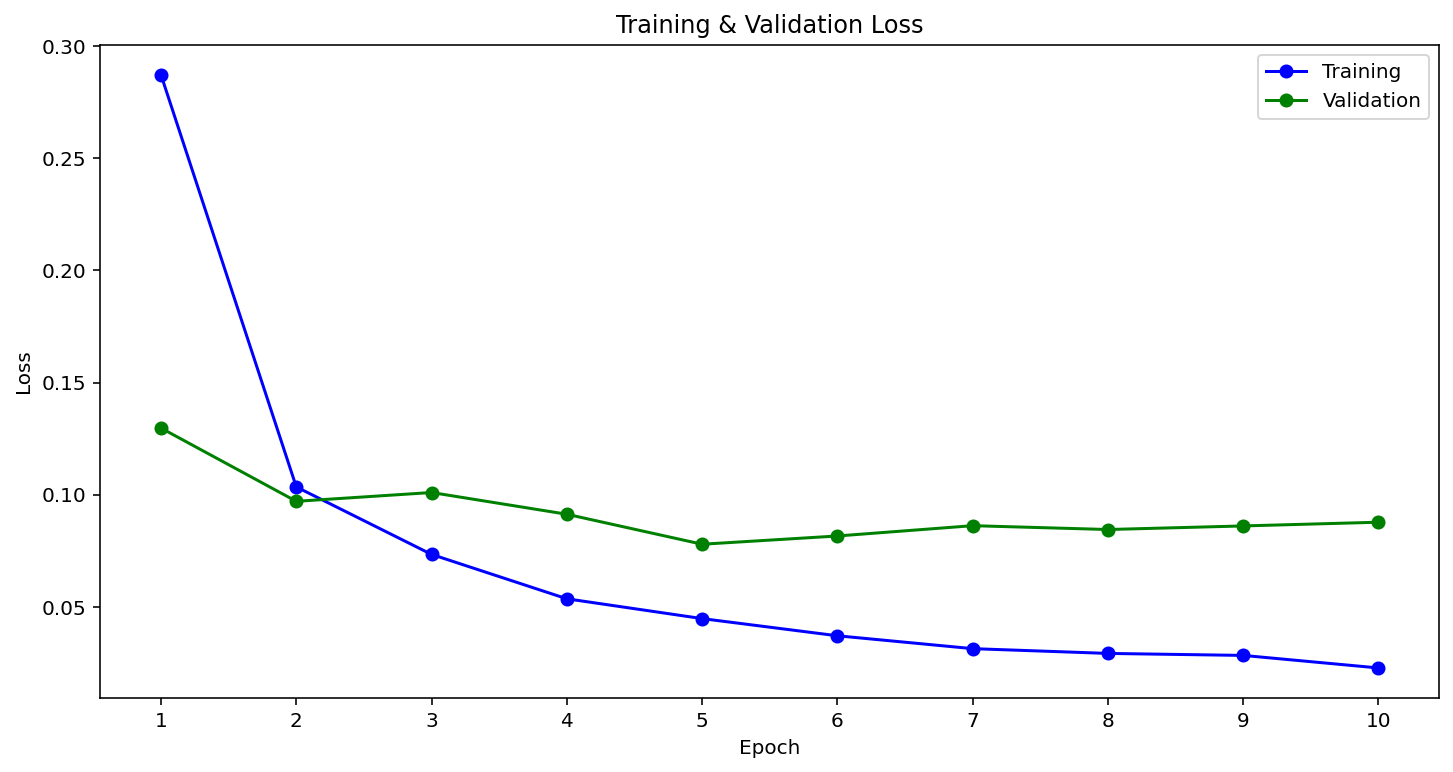



---------------------------
| Accuracy   | Value      |
---------------------------
| Training   | 0.996437   |
---------------------------
| Test       | 0.977209   |
---------------------------


In [9]:
#YOUR CODE HERE
# Using batch normalization
net_batchnorm = MLP_extended(dimx=784, hidden1=128, hidden2=64, nlabels=10, epochs=10, print_every=1, use_batch_norm=True)
net_batchnorm.trainloop(trainloader, validloader)
plot_loss_curves(net_batchnorm.loss_during_training, net_batchnorm.valid_loss_during_training)
net_batchnorm_train_acc, net_batchnorm_test_acc = model_evaluation(net_batchnorm, trainloader, testloader)

----------------------------------------------------------------
| Epoch | Training loss   | Validation loss   | Elapsed time   |
----------------------------------------------------------------
| 1     | 0.426794        | 0.289585          | 0:00:16        |
----------------------------------------------------------------
| 2     | 0.211258        | 0.191914          | 0:00:16        |
----------------------------------------------------------------
| 3     | 0.152372        | 0.153203          | 0:00:16        |
----------------------------------------------------------------
| 4     | 0.120435        | 0.130224          | 0:00:16        |
----------------------------------------------------------------
| 5     | 0.102986        | 0.117537          | 0:00:23        |
----------------------------------------------------------------
| 6     | 0.0872907       | 0.110596          | 0:00:16        |
----------------------------------------------------------------
| 7     | 0.0770128      

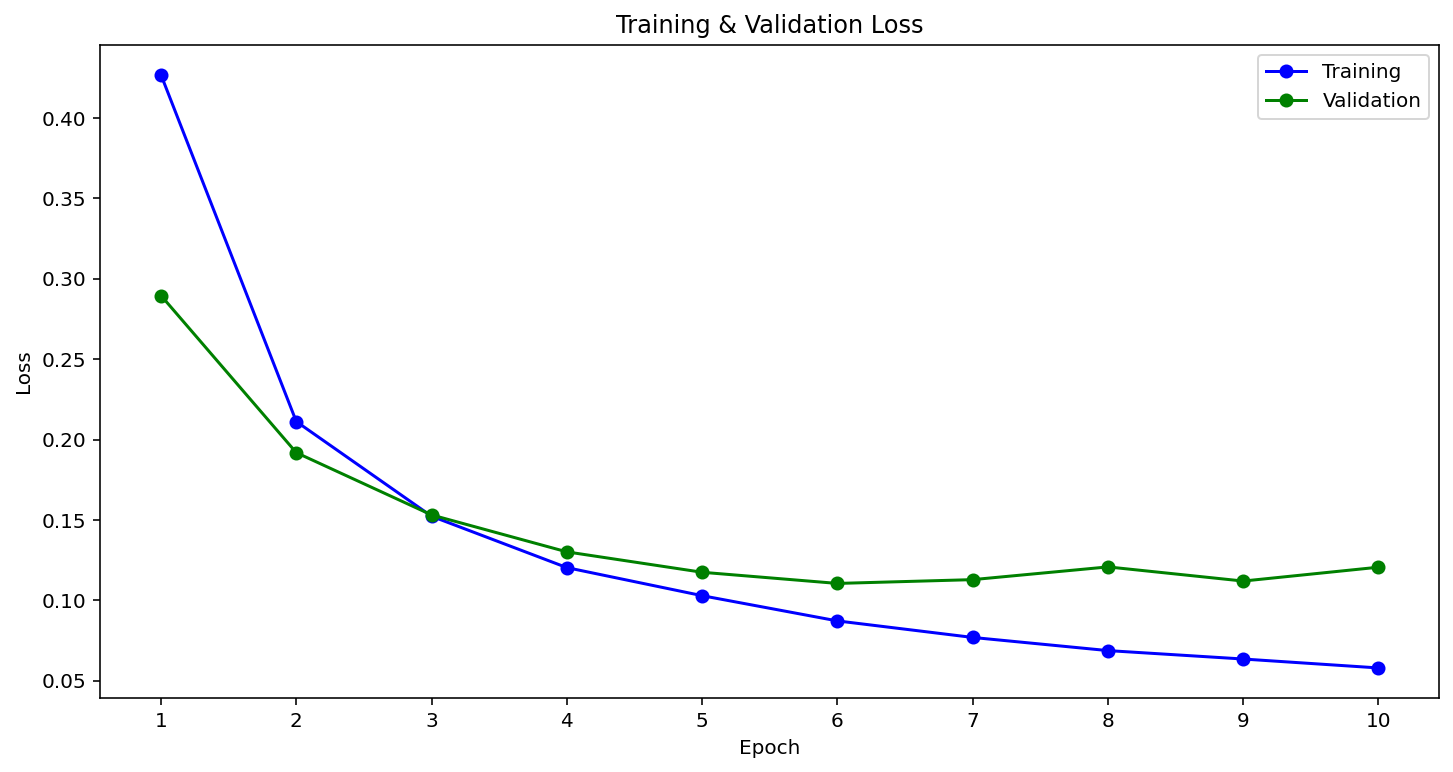



---------------------------
| Accuracy   | Value      |
---------------------------
| Training   | 0.981583   |
---------------------------
| Test       | 0.968252   |
---------------------------


In [10]:
# Without batch normalization
net_no_norm = MLP_extended(dimx=784, hidden1=128, hidden2=64, nlabels=10, epochs=10, print_every=1, use_batch_norm=False)
net_no_norm.trainloop(trainloader, validloader)
plot_loss_curves(net_no_norm.loss_during_training, net_no_norm.valid_loss_during_training)
net_no_norm_train_acc, net_no_norm_test_acc = model_evaluation(net_no_norm, trainloader, testloader)

---
### Considerations for other network types

This notebook demonstrates batch normalization in a standard neural network with fully connected layers. You can also use batch normalization in other types of networks, but there are some special considerations.

#### ConvNets

Convolution layers consist of multiple feature maps. (Remember, the depth of a convolutional layer refers to its number of feature maps.) And the weights for each feature map are shared across all the inputs that feed into the layer. Because of these differences, batch normalizing convolutional layers requires batch/population mean and variance per feature map rather than per node in the layer.

> To apply batch normalization on the outputs of convolutional layers, we use [BatchNorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d). To use it, we simply state the **number of input feature maps**. I.e. `nn.BatchNorm2d(num_features=nmaps)`


#### RNNs

Batch normalization can work with recurrent neural networks, too, as shown in the 2016 paper [Recurrent Batch Normalization](https://arxiv.org/abs/1603.09025). It's a bit more work to implement, but basically involves calculating the means and variances per time step instead of per layer. You can find an example where someone implemented recurrent batch normalization in PyTorch, in [this GitHub repo](https://github.com/jihunchoi/recurrent-batch-normalization-pytorch).

> **Exercise:** Using CIFAR10 database, incorporate BN to your solution of Lab 3 (Part I). Compare the results with and without BN!!

In [11]:
#YOUR CODE HERE
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import random_split

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

data_samples = len(trainset)
val_size = 0.2
val_samples = int(data_samples * val_size)
train_samples = data_samples - val_samples

trainset, valset = random_split(trainset, [train_samples, val_samples], generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

validloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
class Lenet5(nn.Module):
    def __init__(self, dimx, nlabels, use_batch_norm): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x6 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Linear layers
        self.linear1 = nn.Linear(400,120) #YOUR CODE HERE
        
        self.linear2 = nn.Linear(120,84) #YOUR CODE HERE
        
        self.linear3 = nn.Linear(84,nlabels) #YOUR CODE HERE
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)

        self.use_batch_norm = use_batch_norm
        if self.use_batch_norm:

            self.batch_norm1 = nn.BatchNorm2d(6)
            self.batch_norm2 = nn.BatchNorm2d(16)
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = self.relu(x)
        x = self.pool(x)
 
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view((x.shape[0], x.shape[1]*(self.final_dim**2)))

        # Pass the tensor through the Dense Layers
        x = self.linear1(x) #YOUR CODE HERE
        x = self.relu(x)    #YOUR CODE HERE
        x = self.linear2(x) #YOUR CODE HERE
        x = self.relu(x)    #YOUR CODE HERE
        x = self.linear3(x) #YOUR CODE HERE
        x = self.logsoftmax(x) 
        return x


In [13]:
class Lenet5_extended(Lenet5):
    
    #Your code here
    
    def __init__(self,dimx,nlabels, use_batch_norm=True, epochs=100,lr=0.001, print_every=5):
        
        super().__init__(dimx, nlabels, use_batch_norm)  
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()  

        self.print_every = print_every          
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 
        
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # =======================================
        #               Training
        # =======================================

        print('-'*64)
        print(f"| {'Epoch':<5} | {'Training loss':<15} | {'Validation loss':<17} | {'Elapsed time':<14} |")
        print('-'*64)
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                #Reset Gradients!
                #YOUR CODE HERE
                self.optim.zero_grad()
            
                out = self.forward(images)

                #Your code here
                loss = self.criterion(out,labels)

                running_loss += loss.item()

                #Compute gradients
                #YOUR CODE HERE
                loss.backward()
                
                #SGD stem
                #YOUR CODE HERE
                self.optim.step()
                
                
            self.loss_during_training.append(running_loss/len(trainloader))
            
            # =======================================
            #               Validation
            # =======================================
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():            
                
                running_loss = 0.
                
                for images,labels in validloader:
                    
                    # Move input and label tensors to the default device
                    images, labels = images.to(self.device), labels.to(self.device) #YOUR CODE HERE                    
                    
                    # Compute output for input minibatch
                    out = out = self.forward(images) #YOUR CODE HERE

                    #Your code here
                    loss = self.criterion(out, labels) #YOUR CODE HERE

                    running_loss += loss.item()   
                    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
                    

            # Print training and validation results
            if((e+1) % self.print_every == 0):
                print(f"| {e+1:<5} | {self.loss_during_training[-1]:<15.6} | {self.valid_loss_during_training[-1]:<17.6} | {format_time(time.time() - start_time):<14} |")
                print('-'*64)
                

    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) #YOUR CODE HERE 
                probs = logprobs = self.forward(images) #YOUR CODE HERE

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader)

----------------------------------------------------------------
| Epoch | Training loss   | Validation loss   | Elapsed time   |
----------------------------------------------------------------
| 1     | 1.52762         | 1.34535           | 0:00:17        |
----------------------------------------------------------------
| 2     | 1.25529         | 1.21299           | 0:00:18        |
----------------------------------------------------------------
| 3     | 1.14251         | 1.15463           | 0:00:18        |
----------------------------------------------------------------
| 4     | 1.06898         | 1.09345           | 0:00:18        |
----------------------------------------------------------------
| 5     | 1.01243         | 1.06875           | 0:00:18        |
----------------------------------------------------------------


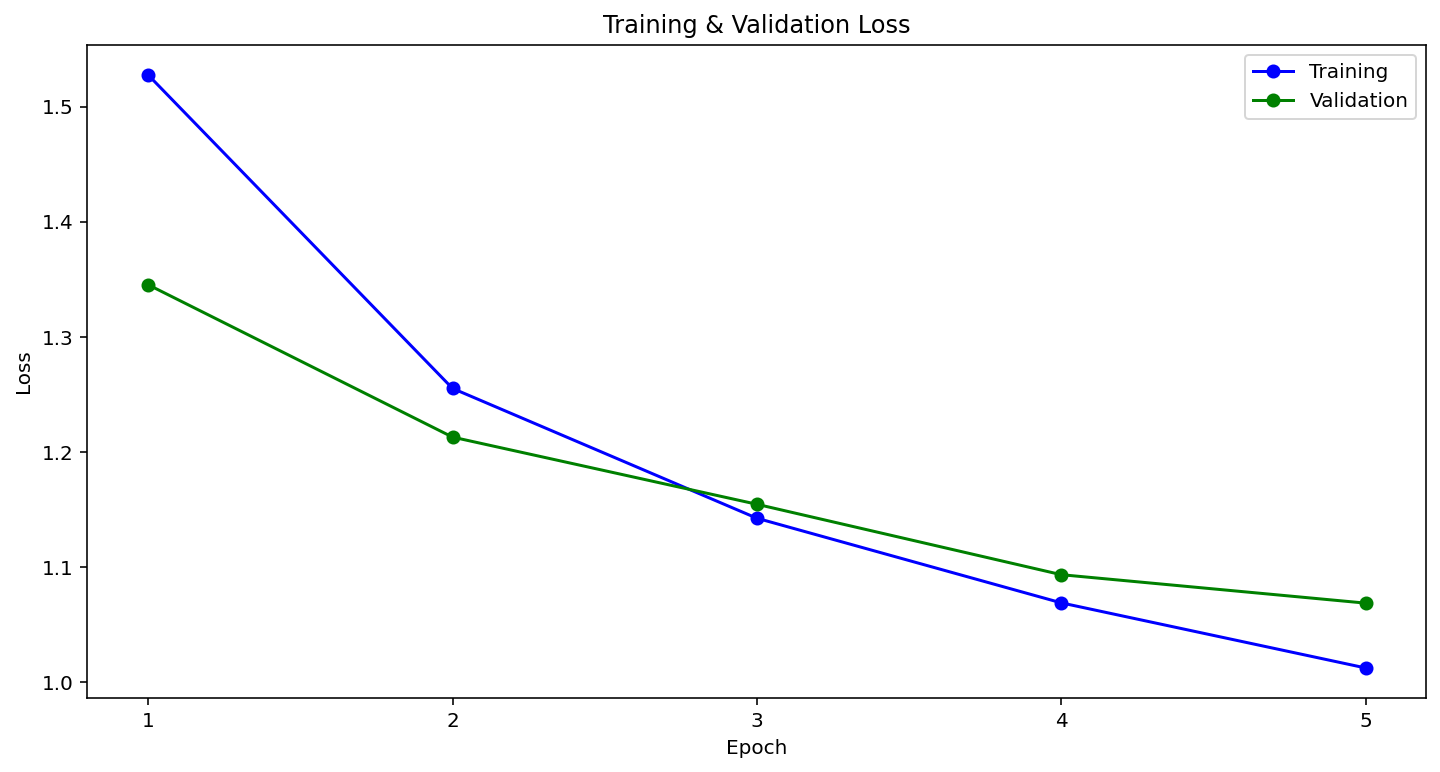



---------------------------
| Accuracy   | Value      |
---------------------------
| Training   | 0.66875    |
---------------------------
| Test       | 0.617735   |
---------------------------


In [14]:
# Using batch normalization
my_CNN_bn = Lenet5_extended(dimx=32, nlabels=10, epochs=5, print_every=1, use_batch_norm=True)
my_CNN_bn.trainloop(trainloader, validloader)
plot_loss_curves(my_CNN_bn.loss_during_training, my_CNN_bn.valid_loss_during_training)
my_CNN_bn_train_acc, my_CNN_bn_test_acc = model_evaluation(my_CNN_bn, trainloader, testloader)

----------------------------------------------------------------
| Epoch | Training loss   | Validation loss   | Elapsed time   |
----------------------------------------------------------------
| 1     | 1.72759         | 1.46659           | 0:00:17        |
----------------------------------------------------------------
| 2     | 1.39909         | 1.34804           | 0:00:17        |
----------------------------------------------------------------
| 3     | 1.27992         | 1.28023           | 0:00:17        |
----------------------------------------------------------------
| 4     | 1.19185         | 1.19161           | 0:00:17        |
----------------------------------------------------------------
| 5     | 1.12771         | 1.16085           | 0:00:17        |
----------------------------------------------------------------


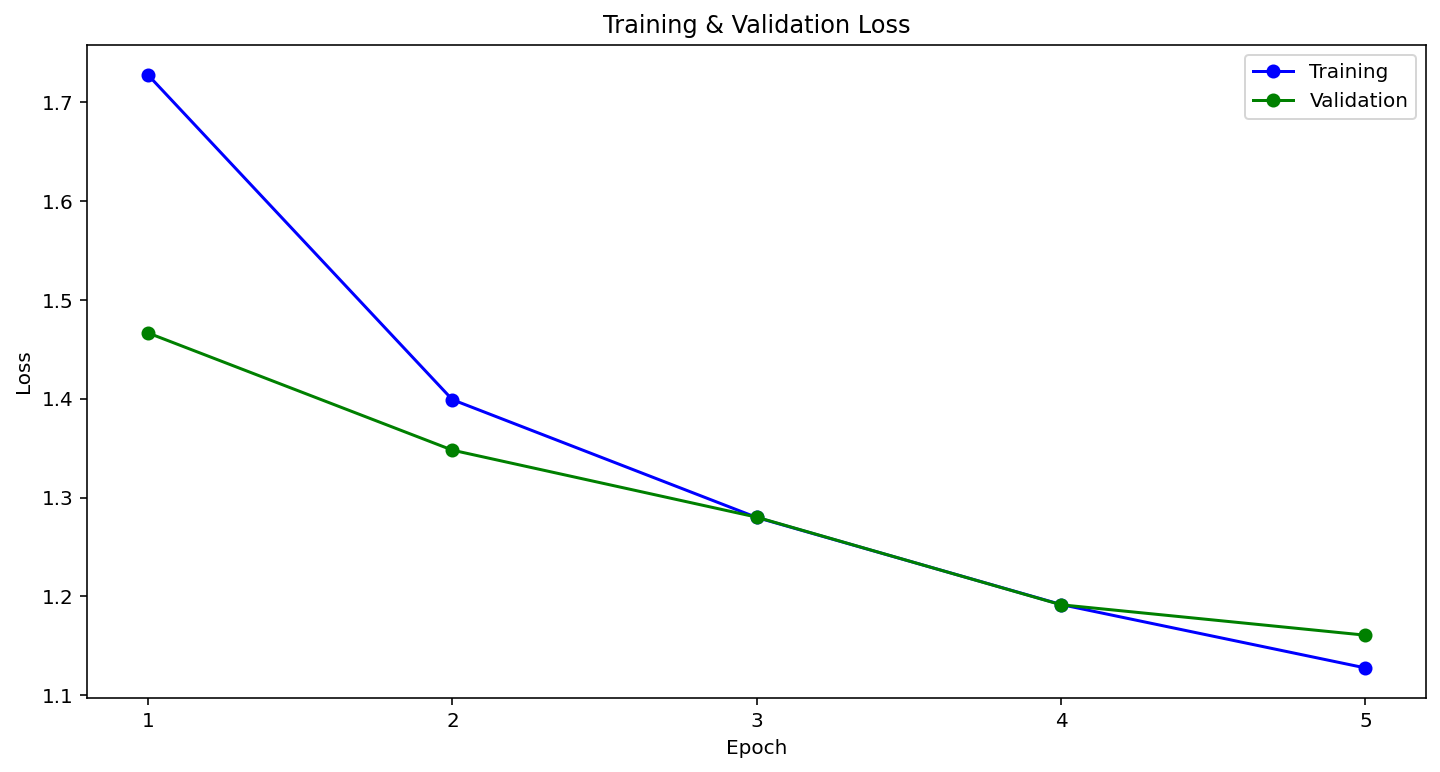



---------------------------
| Accuracy   | Value      |
---------------------------
| Training   | 0.626      |
---------------------------
| Test       | 0.587779   |
---------------------------


In [15]:
# Without batch normalization
my_CNN_no_bn = Lenet5_extended(dimx=32, nlabels=10, epochs=5, print_every=1, use_batch_norm=False)
my_CNN_no_bn.trainloop(trainloader, validloader)
plot_loss_curves(my_CNN_no_bn.loss_during_training, my_CNN_no_bn.valid_loss_during_training)
my_CNN_bn_train_acc, my_CNN_bn_test_acc = model_evaluation(my_CNN_no_bn, trainloader, testloader)